In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import deepxde as dde

print('TF version: {}'.format(tf.__version__))
print('GPU support enabled: {}'.format(tf.test.is_built_with_gpu_support()))
print('ROCm support enabled: {}'.format(tf.test.is_built_with_rocm()))
print('CUDA support enabled: {}'.format(tf.test.is_built_with_cuda()))

TF version: 1.15.0
GPU support enabled: True
ROCm support enabled: False
CUDA support enabled: True


In [20]:
c_b = 4200 
rho_b = 1e3 
om_b = 5e-4
c = 4200 
h_f = 100
T_c = 37
L = 3e-2
k = 0.5
w_b = c_b*rho_b*om_b
Q_m = 33800
h_0 = 10
T_f = 25
T_a = 37

In [21]:
def analyticSol(x):
    A = np.sqrt(w_b/k)
    lterm = (T_c - T_a - Q_m/w_b) * (A * np.cosh(A * x)  +\
                +  (h_0/k) * np.sinh(A * x)) / (A * np.cosh(A * L) + (h_0/k) * np.sinh(A * L))
    rterm = h_0/k * (T_f - T_a - Q_m/w_b) * np.sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * np.cosh(A * L) + (h_0/k) * np.sinh(A * L)) 

    return  T_a + Q_m/w_b + lterm + rterm

In [22]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_xx = tf.gradients(dy_x, x)[0]
    return dy_xx - (w_b/k)*y + (w_b*T_a + Q_m)/k

def boundary(x, on_boundary):
    return on_boundary

In [23]:
geom = dde.geometry.Interval(0, L)
bc_l = dde.RobinBC(geom, lambda x, y: (h_0/k)*y - (h_0*T_f/k), boundary)
bc_r = dde.DirichletBC(geom, lambda x: x*0 + T_c, boundary)
data = dde.data.PDE(geom, 1, pde, [bc_l, bc_r], 16, 2, func=analyticSol, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000, uncertainty=True)

Building feed-forward neural network...
'build' took 0.056564 s

Compiling model...
'compile' took 0.559709 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.97e+10, 2.50e+05, 1.37e+03]    [4.97e+10, 0.00e+00, 0.00e+00]    [1.00e+00]    
1000      [7.65e+08, 1.85e+05, 9.04e+01]    [7.65e+08, 0.00e+00, 0.00e+00]    [9.48e-02]    
2000      [4.27e+05, 3.12e+05, 2.54e+02]    [4.27e+05, 0.00e+00, 0.00e+00]    [2.35e-01]    
3000      [1.39e+01, 3.16e+05, 2.59e+02]    [1.31e+01, 0.00e+00, 0.00e+00]    [2.39e-01]    
4000      [1.11e+01, 3.16e+05, 2.59e+02]    [1.03e+01, 0.00e+00, 0.00e+00]    [2.39e-01]    
5000      [1.00e+01, 3.16e+05, 2.59e+02]    [9.33e+00, 0.00e+00, 0.00e+00]    [2.39e-01]    
6000      [9.39e+00, 3.16e+05, 2.59e+02]    [8.71e+00, 0.00e+00, 0.00e+00]    [2.39e-01]    
7000      [9.02e+00, 3.16e+05, 2.59e+02]    [8.36e+00, 0.00e+00, 0.00e+00]    [2.39e-01]    
8000   

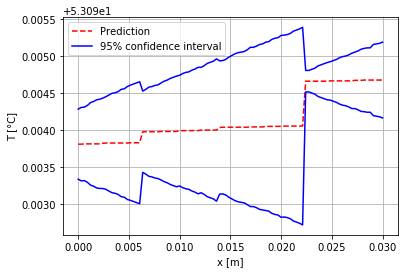

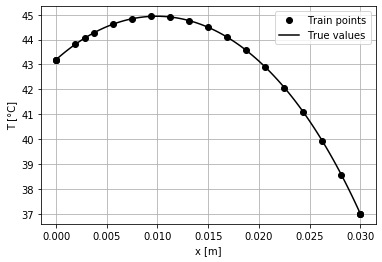

In [24]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
y_dim = y_train.shape[1]
idx = np.argsort(X_test[:, 0])
X = X_test[idx, 0]

# regression plot
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(y_dim):
    #ax.plot(X_train[:, 0], y_train[:, i], 'ok', label='Train points')
    #ax.plot(X, y_test[idx, i], "-k", label='True values')
    ax.plot(X, best_y[idx, i], "--r", label='Prediction')
    if best_ystd is not None:
        ax.plot(X, best_y[idx, i] + 2 * best_ystd[idx, i], '-b', label='95% confidence interval')
        ax.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], '-b')
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(y_dim):
    ax.plot(X_train[:, 0], y_train[:, i], 'ok', label='Train points')
    ax.plot(X, y_test[idx, i], "-k", label='True values')
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')
plt.show()

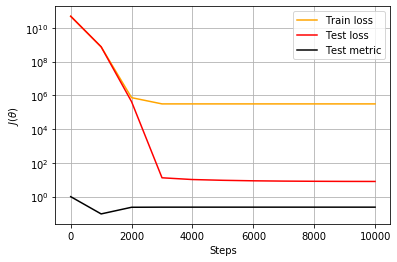

In [25]:
loss_train = np.sum(
    np.array(losshistory.loss_train) * losshistory.loss_weights, axis=1
)
loss_test = np.sum(
    np.array(losshistory.loss_test) * losshistory.loss_weights, axis=1
)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(losshistory.steps, loss_train, color='orange', label="Train loss")
ax.semilogy(losshistory.steps, loss_test, color='red', label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    ax.semilogy(losshistory.steps, np.array(losshistory.metrics_test)[:, i], color='black', label="Test metric",)
ax.set_xlabel('Steps')
ax.set_ylabel(r'$J(\theta)$')
plt.grid()
plt.legend(loc='best')
plt.show()